# **Predicting Popular Recipes**

# 1. Introduction

The Tasty Bytes product team would like to know if there is a way to predict which recipes, if featured on the company's home page, would lead to high website traffic. These predictions should be correct at least 80% of the time. An automated system for choosing popular recipes would benefit the organization in terms of increasing website traffic and subscriptions to meal planning and ingredient delivery services.

Therefore, the goals of this analysis were to train and evaluate predictive models, then make recommendations for steps forward. This technical report includes code, code output, and written summaries organized in the following sections: 2. Data Validation, 3. Exploratory Analysis, 4. Model Development, 5. Model Evaluation, 6. Key Performance Indicator, and 7. Summary and Recommendations.

In [1]:
# import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import label_binarize, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# set pandas display precision to 3 places after decimal
pd.set_option('display.precision', 3)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
filename = 'recipe_site_traffic_2212.csv'
data = pd.read_csv(filename)

In [3]:
# preview data
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
# display number of rows and columns
data.shape

(947, 8)

In [5]:
# check for duplicate rows based on all columns
data.duplicated().sum()

0

In [6]:
# check column data types and number of non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [7]:
# 'recipe' is not a feature nor target variable for this predictive modeling application.
# set 'recipe' as the index, as it may be an important reference to recipes later.
data = data.set_index('recipe')

# confirm change
data.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [8]:
# get unique values: 'servings'
data['servings'].value_counts()

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [9]:
# 'servings' column: replace '4 as a snack' and '6 as a snack' with '4' and '6', respectively
data['servings'] = data['servings'].replace(to_replace='4 as a snack', value='4')
data['servings'] = data['servings'].replace(to_replace='6 as a snack', value='6')

# confirm change
data['servings'].value_counts()

servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

In [10]:
# convert 'servings' to integer
data['servings'] = data['servings'].astype('int')

# confirm change
data.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int32
high_traffic     object
dtype: object

In [11]:
# check numeric column descriptive statistics
data.describe()

,calories,carbohydrate,sugar,protein,servings
count,895.000,895.000,895.000,895.000,947.000
mean,435.939,35.070,9.047,24.149,3.477
std,453.021,43.949,14.679,36.370,1.733
min,0.140,0.030,0.010,0.000,1.000
25%,110.430,8.375,1.690,3.195,2.000
50%,288.550,21.480,4.550,10.800,4.000
75%,597.650,44.965,9.800,30.200,4.000
max,3633.160,530.420,148.750,363.360,6.000


In [12]:
# ranges (minimum and maximum values) appear appropriate for all numeric variables except the 0 minimum for 'protein'.
# inspect each row containing 0 for 'protein' to determine if the value is plausible.
data[data['protein'] == 0]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
469,27.11,22.63,4.93,0.0,Beverages,1,NaN
813,550.71,11.53,0.35,0.0,Potato,2,High


In [13]:
# it is plausible for a beverage to contain 0 g protein (recipe 469).
# however, it is highly unlikely that a recipe categorized as 'potato' would contain 0 g of protein (recipe 813).
# therefore, mark the 0 value in the 'potato' recipe as null since it is likely an error.
data.loc[(data['protein'] == 0) & (data['category'] == 'Potato'), 'protein'] = np.nan

# confirm change
data[data['protein'] == 0]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
469,27.11,22.63,4.93,0.0,Beverages,1,NaN


In [14]:
# get unique values: 'category'
display(data['category'].value_counts())
print('Number of unique values: {}'.format(data['category'].nunique()))

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

Number of unique values: 11


In [15]:
# 'Chicken Breast' is the only value that does not conform to the data dictionary.
# replace 'Chicken Breast' with 'Chicken' in the 'category' column.
data.loc[data['category'] == 'Chicken Breast', 'category'] = 'Chicken'

# confirm change
display(data['category'].value_counts())
print('Number of unique values: {}'.format(data['category'].nunique()))

category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: count, dtype: int64

Number of unique values: 10


In [16]:
# get unique values: 'high_traffic'
display(data['high_traffic'].value_counts())
print('Number of unique values: {}'.format(data['high_traffic'].nunique()))

# display number of null values
print('Number of null values: {}'.format(data['high_traffic'].isna().sum()))

high_traffic
High    574
Name: count, dtype: int64

Number of unique values: 1
Number of null values: 373


In [17]:
# I assume that all null values refer to 'Not High' website traffic.
# replace null values with 'Not High' in the 'high_traffic' column.
data.loc[data['high_traffic'].isna(), 'high_traffic'] = 'Not High'

# confirm change
display(data['high_traffic'].value_counts())
print('Number of unique values: {}'.format(data['high_traffic'].nunique()))
print('Number of null values: {}'.format(data['high_traffic'].isna().sum()))

high_traffic
High        574
Not High    373
Name: count, dtype: int64

Number of unique values: 2
Number of null values: 0


In [18]:
# display number of null values per column
data.isna().sum()

calories        52
carbohydrate    52
sugar           52
protein         53
category         0
servings         0
high_traffic     0
dtype: int64

In [19]:
# inspect rows with null value in any column
data[data.isna().any(axis=1)]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
24,NaN,NaN,NaN,NaN,Meat,2,Not High
49,NaN,NaN,NaN,NaN,Chicken,4,Not High
83,NaN,NaN,NaN,NaN,Meat,4,High
90,NaN,NaN,NaN,NaN,Pork,6,High
117,NaN,NaN,NaN,NaN,Chicken,6,High
122,NaN,NaN,NaN,NaN,Dessert,2,High
137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
150,NaN,NaN,NaN,NaN,Potato,2,High


In [20]:
# 52 rows have null values for 'calories', 'carbohydrate', 'sugar', and 'protein'.
# 1 row has a null value for 'protein' only.

# 2. Data Validation

The dataset provided by the product team contains recipe characteristics as well as a column indicating if website traffic was high when each recipe was featured on the home page. Validation was performed to understand the dataset's dimensions, identify any duplicate rows, identify any null values, identify any abnormal values, and ensure each column matches its corresponding description in the data dictionary. When a column did not conform to its description in the data dictionary, appropriate cleaning techniques were applied to the data.

Overall, the original dataset comprised 947 rows and 8 columns, 0 duplicate rows, and 52 rows with null values. The following list summarizes the inspection and resulting data cleaning of each column:

- **recipe**:
  - Correct data type (integer/numeric)
  - This column is not a feature nor target variable. It is a unique identifier for each recipe. Therefore, it was set as the index, as it may be a useful future reference to recipes.
- **calories**:
  - Correct data type (float/numeric)
  - Minimum and maximum values appear appropriate
  - There are 52 null values
- **carbohydrate**:
  - Correct data type (float/numeric)
  - Minimum and maximum values appear appropriate
  - There are 52 null values
- **sugar**:
  - Correct data type (float/numeric)
  - Minimum and maximum values appear appropriate
  - There are 52 null values
- **protein**:
  - Correct data type (float/numeric)
  - The maximum value appeared appropriate. However, the minimum value was 0. Upon inspection of the 2 rows with 0 for 'protein', one recipe was categorized as 'Beverage' and the other 'Potato'. While it is plausible for a beverage recipe to contain 0 g of protein per serving, a recipe with potatoes likely contains some amount of protein per serving and the 0 value was likely an error. Therefore, for the 'potato' recipe, the 0 value for protein was changed to null.
  - After the change, there is 1 null value
- **category**:
  - Correct data type (object/character)
  - There were originally 11 unique values. Values of 'Chicken Breast' were changed to 'Chicken'. Then, there were 10 unique values which matched those in the data dictionary ('Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').
  - There are 0 null values
- **servings**:
  - Incorrect data type (object/character)
  - Values of '4 as a snack' and '6 as a snack' were changed to '4' and '6', respectively. Then the data type of the column was changed to integer/numeric.
  - The minimum and maximum values appear appropriate
  - There are 0 null values
- **high_traffic**:
  - Correct data type (object/character)
  - There were 574 rows with a value of 'High' and the remaining 373 rows had null values. With the assumption that all null values refer to website traffic that was not 'High', the null values were changed to 'Not High'.

The cleaned dataset comprised 947 rows and 7 columns, 0 duplicate rows, and 53 rows with null values.

# 3. Exploratory Analysis

Exploratory analysis of the cleaned dataset was performed to understand the distribution and descriptive statistics of each variable as well as how data characteristics may differ between recipes associated with 'High' and 'Not High' website traffic. The analysis is organized in the following subsections: 3.1 Numeric Variables, 3.2 Categorical Variables, and 3.3 Comparison of Two Groups.

## 3.1 Numeric Variables

Table 1 and Figure 1 show descriptive statistics and a multivariate boxplot of the numeric variables, respectively. The numeric variables have different value ranges (Table 1, Figure 1). To examine their distributions in greater detail, Figures 2-6 display histograms for each variable. The continuous variables (i.e., 'calories', 'carbohydrate', 'sugar', 'protein') are heavily right-skewed (Figures 2-5). Meanwhile, the discrete variable 'servings' has a slight left skew (Figure 6).

Table 1: Descriptive statistics for numeric variables.

In [21]:
# generate numeric column descriptive statistics table
data.describe()

,calories,carbohydrate,sugar,protein,servings
count,895.000,895.000,895.000,894.000,947.000
mean,435.939,35.070,9.047,24.176,3.477
std,453.021,43.949,14.679,36.381,1.733
min,0.140,0.030,0.010,0.000,1.000
25%,110.430,8.375,1.690,3.212,2.000
50%,288.550,21.480,4.550,10.805,4.000
75%,597.650,44.965,9.800,30.340,4.000
max,3633.160,530.420,148.750,363.360,6.000


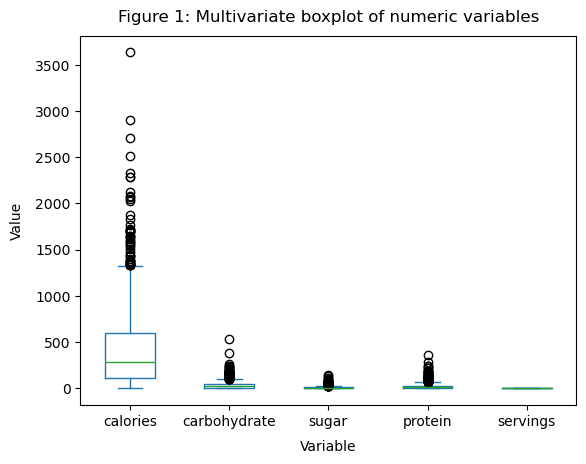

In [22]:
# generate boxplot: numeric columns
data.plot(kind='box')
plt.title('Figure 1: Multivariate boxplot of numeric variables', pad=10.0)
plt.xlabel('Variable', labelpad=8.0)
plt.ylabel('Value', labelpad=8.0)
plt.show()

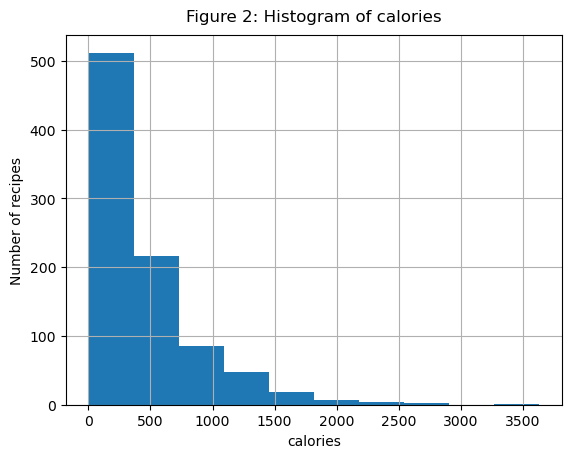

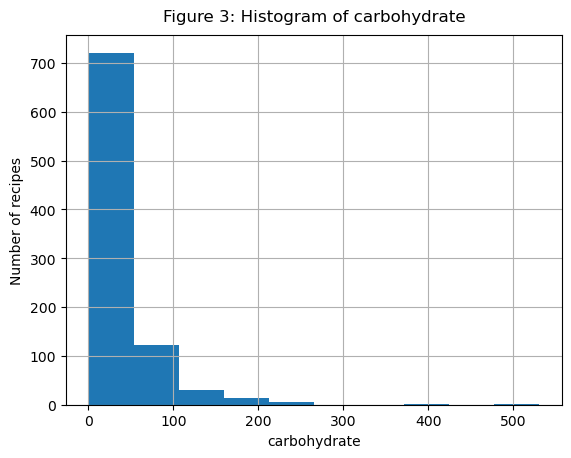

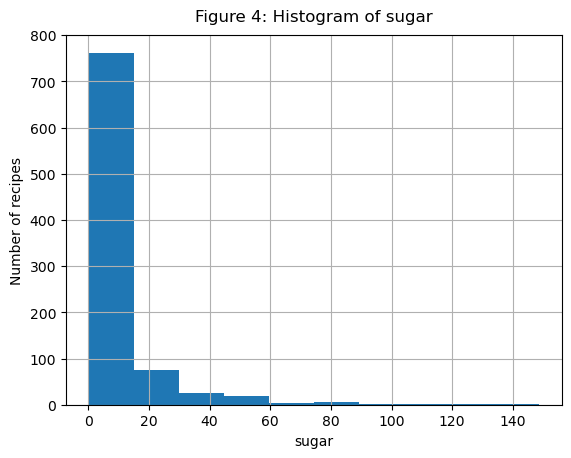

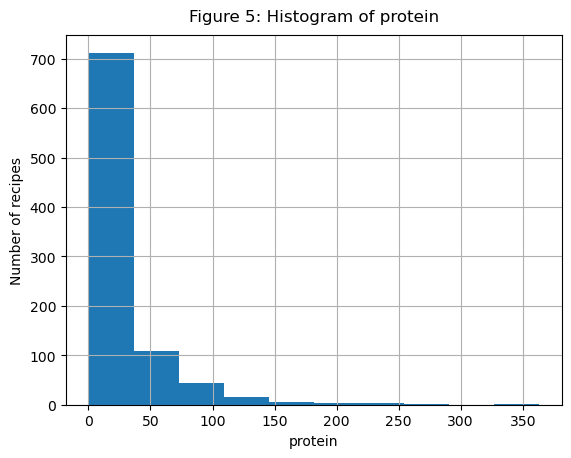

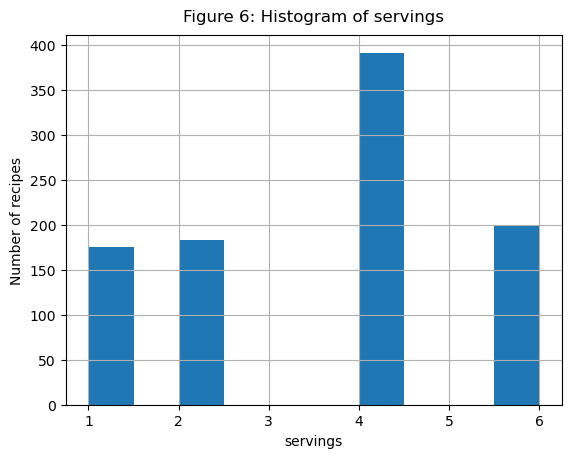

In [23]:
# generate histograms of numeric variables

# define a list of column names for looping
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']

# define first figure number
fig_num = 2

# loop through each numeric column to generate histogram and increment fig_num by 1
for col in numeric_cols:
    data[col].hist()
    plt.title(f'Figure {fig_num}: Histogram of {col}', pad=10.0)
    fig_num += 1
    plt.xlabel(col, labelpad=4.0)
    plt.ylabel('Number of recipes', labelpad=4.0)
    plt.show()

Due to the differing scales and non-normal distributions of the numeric variables, each variable will be power transformed (i.e., the distributions will be made more Gaussian). This preprocessing technique is important because some machine learning algorithms perform better when numeric variables are on a common scale and are normally distributed.

## 3.2 Categorical Variables

The categorical variables were examined to explore data proportions. Figures 7 and 8 show the proportion of recipes in each category of the 'category' and 'high_traffic' variables, respectively. 'Chicken' is the most common category (18% of recipes), followed by 'Breakfast' (11%) and 'Beverages' (10%) (Figure 7). The remaining categories each comprise 7-9% of the recipes (Figure 7). In terms of website traffic, 61% of the recipes are associated with 'High' traffic, while 39% are associated with 'Not High' traffic (Figure 8).

In [24]:
# display proportion of recipes by category and high_traffic
display(data['category'].value_counts(normalize=True).round(2))
display(data['high_traffic'].value_counts(normalize=True).round(2))

category
Chicken          0.18
Breakfast        0.11
Beverages        0.10
Lunch/Snacks     0.09
Potato           0.09
Pork             0.09
Vegetable        0.09
Dessert          0.09
Meat             0.08
One Dish Meal    0.07
Name: proportion, dtype: float64

high_traffic
High        0.61
Not High    0.39
Name: proportion, dtype: float64

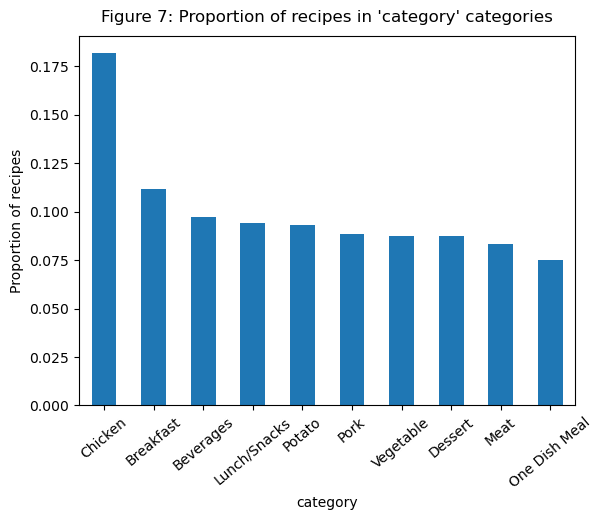

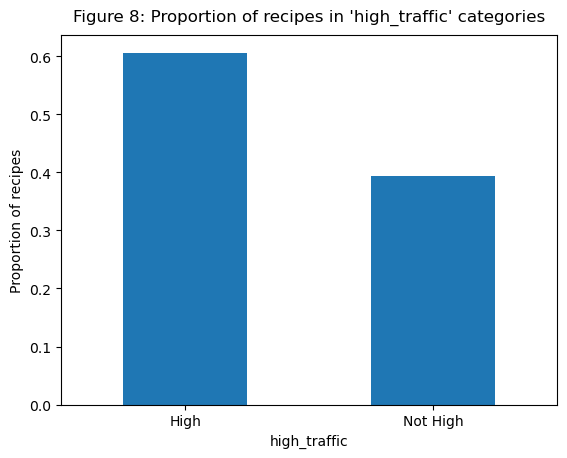

In [25]:
# generate bar plot: category
data['category'].value_counts(normalize=True).plot(kind='bar', rot=40)
plt.title("Figure 7: Proportion of recipes in 'category' categories", pad=10.0)
plt.xlabel('category', labelpad=4.0)
plt.ylabel('Proportion of recipes', labelpad=4.0)
plt.show()

# generate bar plot: high_traffic
data['high_traffic'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title("Figure 8: Proportion of recipes in 'high_traffic' categories", pad=10.0)
plt.xlabel('high_traffic', labelpad=4.0)
plt.ylabel('Proportion of recipes', labelpad=4.0)
plt.show()

Because machine learning models generally require all variables to be numeric, the categorical variables will be preprocessed. The 'category' variable will be one-hot encoded, which will create a binary variable for each category and remove the original variable. The 'high_traffic' variable will be encoded with binary values: 0 for 'Not High' and 1 for 'High'.

## 3.3 Comparison of Two Groups

The recipes associated with 'High' and 'Not High' website traffic were visually compared in terms of their data distributions in each column. Figures 9-13 show box plots of each numeric variable grouped by the 'high_traffic' column. From a visual inspection of these plots, there is no apparent difference between 'High' and 'Not High' recipes with respect to 'calories', 'carbohydrate', 'sugar', 'protein', or 'servings'. From this visual exploration, it's unclear if these variables will be useful for distinguishing between 'High' and 'Not High' recipes.

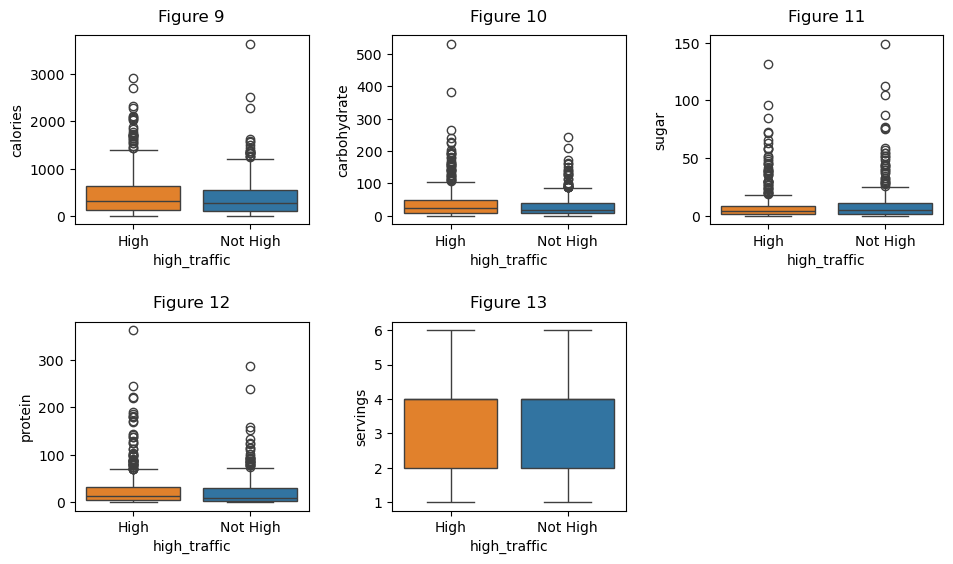

In [26]:
# generate boxplots of numeric variables grouped by 'high_traffic'

# set up figure with subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))

# generate histogram: calories
sns.boxplot(data=data, x='high_traffic', y='calories', ax=ax[0,0], palette=['#ff7f0e','#1f77b4'])
ax[0,0].set_title('Figure 9', pad=10.0)
ax[0,0].set_xlabel('high_traffic', labelpad=4.0)
ax[0,0].set_ylabel('calories', labelpad=4.0)

# generate histogram: carbohydrate
sns.boxplot(data=data, x='high_traffic', y='carbohydrate', ax=ax[0,1], palette=['#ff7f0e','#1f77b4'])
ax[0,1].set_title('Figure 10', pad=10.0)
ax[0,1].set_xlabel('high_traffic', labelpad=4.0)
ax[0,1].set_ylabel('carbohydrate', labelpad=4.0)

# generate histogram: sugar
sns.boxplot(data=data, x='high_traffic', y='sugar', ax=ax[0,2], palette=['#ff7f0e','#1f77b4'])
ax[0,2].set_title('Figure 11', pad=10.0)
ax[0,2].set_xlabel('high_traffic', labelpad=4.0)
ax[0,2].set_ylabel('sugar', labelpad=4.0)

# generate histogram: protein
sns.boxplot(data=data, x='high_traffic', y='protein', ax=ax[1,0], palette=['#ff7f0e','#1f77b4'])
ax[1,0].set_title('Figure 12', pad=10.0)
ax[1,0].set_xlabel('high_traffic', labelpad=4.0)
ax[1,0].set_ylabel('protein', labelpad=4.0)

# generate histogram: servings
sns.boxplot(data=data, x='high_traffic', y='servings', ax=ax[1,1], palette=['#ff7f0e','#1f77b4'])
ax[1,1].set_title('Figure 13', pad=10.0)
ax[1,1].set_xlabel('high_traffic', labelpad=4.0)
ax[1,1].set_ylabel('servings', labelpad=4.0)

# adjust subplot spacing
fig.tight_layout(pad=2.0)

# remove unused subplot
plt.delaxes(ax=ax[1,2])

# display subplots
plt.show()

Figure 14 shows the proportion of recipes in each category of the 'category' variable, grouped by the 'high_traffic' column. Unlike the numeric variable box plots above, this plot displays apparent differences between the 'High' and 'Not High' recipes. For example, recipes categorized as 'vegetable', 'potato', and 'pork' tend to be associated with high website traffic. Conversely, recipes categorized as 'beverages' and 'breakfast' tend to be associated with 'not high' website traffic (Figure 14). It is important to note that the 'high_traffic' column contains a slight class imbalance (i.e., 39% 'Not High' and 61% 'High'). Therefore, some imbalance is expected for each recipe category. Nevertheless, the 'category' column of the dataset will likely be a useful predictor of website traffic.

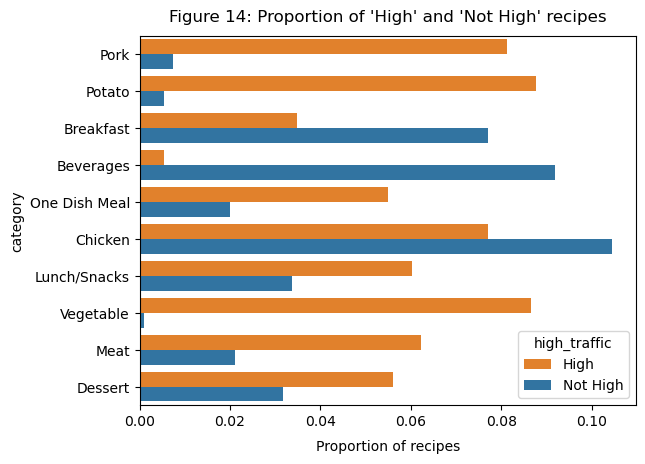

In [27]:
# generate bar plot of the proportion of recipes in each category of 'category', grouped by 'high_traffic'
sns.countplot(data=data, y='category', hue='high_traffic', stat='proportion', palette=['#ff7f0e','#1f77b4'])
plt.title("Figure 14: Proportion of 'High' and 'Not High' recipes", pad=10.0)
plt.xlabel('Proportion of recipes', labelpad=8.0)
plt.show()

# 4. Model Development

## 4.1 Type of Problem

To recap, the business goal is to predict which recipes, if featured on the company's home page, will lead to high website traffic. Because we have labeled data, this is a supervised machine learning task. Furthermore, because the target variable ('high_traffic') is categorical with two classes ('High' and 'Not High'), this is a binary classification problem.

## 4.2 Data Preprocessing

Before modeling, the data had to be preprocessed. First, the dataset was split into a feature set of predictor variables and a target set of the target variable 'high_traffic'. The target set was binarized, such that 0 was assigned to values of 'Not High' and 1 was assigned to values of 'High'. The feature set and target set were then split into train and test sets. Data splitting was performed such that 80% and 20% of the rows were assigned to the train and test sets, respectively. Additionally, the data splitting was stratified by target class such that the train and test sets had 39% 'Not High' (0) and 61% 'High' (1) recipe proportions. The train sets were used for model training, while the test sets were used for model evaluation.

In [28]:
# split data into X (features) and y (target)
X = data.drop('high_traffic', axis=1)
y = data[['high_traffic']]

# encode target variable with binary values (0 for 'Not High', 1 for 'High')
y =  label_binarize(y, classes=['Not High', 'High'])

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# confirm correct target encoding
unique, counts = np.unique(y, return_counts=True)
proportions = np.round(counts / np.sum(counts), 2)
print('Classes, number of samples, and proportions:')
print(f'y: {unique} {counts} {proportions}')

# confirm target class proportions in train set
unique, counts = np.unique(y_train, return_counts=True)
proportions = np.round(counts / np.sum(counts), 2)
print(f'y_train: {unique} {counts} {proportions}')

# confirm target class proportions in test set
unique, counts = np.unique(y_test, return_counts=True)
print(f'y_test: {unique} {counts} {proportions}')

# confirm 80%/20% train/test splits
print(f'\nDimensions:\nX_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')

Classes, number of samples, and proportions:
y: [0 1] [373 574] [0.39 0.61]
y_train: [0 1] [298 459] [0.39 0.61]
y_test: [0 1] [ 75 115] [0.39 0.61]

Dimensions:
X_train: (757, 6)
X_test: (190, 6)
y_train: (757, 1)
y_test: (190, 1)


Following data splitting, the predictor variables (features) were transformed. Since the numeric and categorical features required different transforms, ColumnTransformer was used to apply the appropriate transform(s) to each feature. Missing values in the numeric features were first imputed using SimpleImputer. The median was used since this is the appropriate statistic for non-normally distributed variables. Then, the numeric features were power transformed using PowerTransformer. The Yeo-Johnson method was used since it accepts non-positive values (i.e., 'protein' contains one row with a value of 0). Finally, the categorical feature ('category') was one-hot encoded using OneHotEncoder. Data leakage did not occur since the imputation, power, and one-hot encoding transforms were fit using the training feature set only.

In [29]:
# create list of transforms to apply to features (SimpleImputer, PowerTransformer to numeric features and OneHotEncoder to categorical feature)
transformers = [
    ('i_p', make_pipeline(SimpleImputer(strategy='median'), PowerTransformer(method='yeo-johnson')), ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']),
    ('ohe', OneHotEncoder(drop=None), ['category'])
]

# instantiate a ColumnTransformer object with list of transforms
col_transformer = ColumnTransformer(transformers=transformers)

# fit column transformer to training features and transform them
X_train_transformed = col_transformer.fit_transform(X_train)

# transform testing features
X_test_transformed = col_transformer.transform(X_test)

The features in the training dataset were examined in terms of their relationships. This is important because some machine learning algorithms such as logistic regression assume there is no multicollinearity (i.e., linear relationship between two or more predictor variables). The variance inflation factor (VIF) was calculated for each feature in the training dataset. Generally, VIF values of 5 or greater indicate that a feature is highly collinear with other features. All VIF values were below 2 (Figure 15), suggesting the absence of strong multicollinearity.

In [30]:
# obtain feature names from ColumnTransformer
col_transformer.get_feature_names_out()

array(['i_p__calories', 'i_p__carbohydrate', 'i_p__sugar', 'i_p__protein',
       'i_p__servings', 'ohe__category_Beverages',
       'ohe__category_Breakfast', 'ohe__category_Chicken',
       'ohe__category_Dessert', 'ohe__category_Lunch/Snacks',
       'ohe__category_Meat', 'ohe__category_One Dish Meal',
       'ohe__category_Pork', 'ohe__category_Potato',
       'ohe__category_Vegetable'], dtype=object)

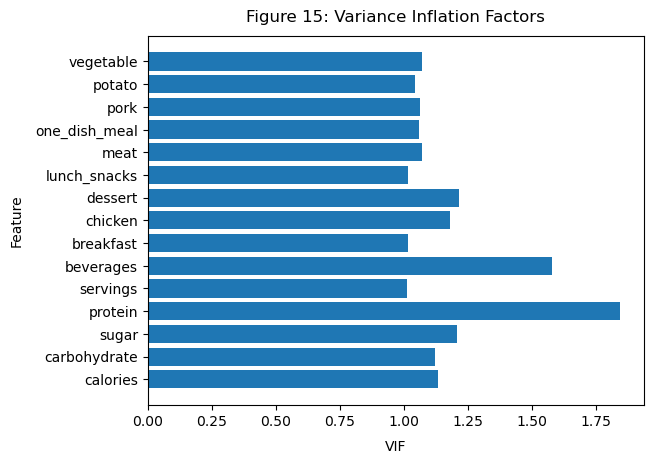

In [31]:
features = ['calories', 'carbohydrate', 'sugar', 'protein',
       'servings', 'beverages',
       'breakfast', 'chicken',
       'dessert', 'lunch_snacks',
       'meat', 'one_dish_meal',
       'pork', 'potato',
       'vegetable']

# create dataframe from X_train_transformed
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=features)

# create VIF dataframe with a row for each feature
vif_df = pd.DataFrame() 
vif_df['feature'] = X_train_transformed_df.columns

# calculate VIF for each feature
vif_df['VIF'] = [variance_inflation_factor(X_train_transformed_df.values, i) for i in range(len(X_train_transformed_df.columns))] 

# generate bar plot of VIF values
plt.barh(vif_df['feature'], vif_df['VIF'])
plt.title('Figure 15: Variance Inflation Factors', pad=10.0)
plt.xlabel('VIF', labelpad=8.0)
plt.ylabel('Feature', labelpad=8.0)
plt.show()

## 4.3 Model Fitting: Spot-Check Multiple Algorithms

To identify two top-performing classification algorithms, the training data and 10-fold cross validation were used to train and evaluate five models that used logistic regression (LR), k-nearest neighbors (KNN), support vector machine (SVM), random forest (RF), and adaboost (AB). Each model was trained using default hyperparameters. The two models with the highest accuracy were logistic regression and SVM (Figure 16). Therefore, these models were chosen for further evaluation.

Median accuracy (IQR):
LR: 0.747 (0.069)
KNN: 0.702 (0.068)
SVM: 0.747 (0.063)
RF: 0.729 (0.065)
AB: 0.72 (0.062)


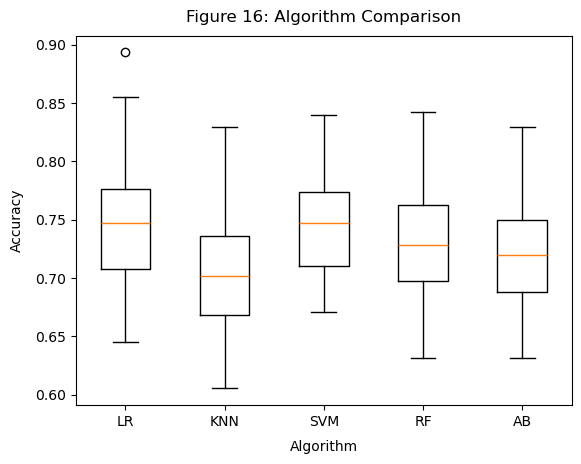

In [32]:
# prepare models to spot-check
models = []
models.append(('LR', LogisticRegression(random_state=1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=1)))
models.append(('RF', RandomForestClassifier(random_state=1)))
models.append(('AB', AdaBoostClassifier(random_state=1)))

# empty lists to store cross-validation results and model names
results = []
names = []

print('Median accuracy (IQR):')

# evaluate one model at a time
for name, model in models:
    # create a pipeline with col_transformer and model
    model = make_pipeline(col_transformer, model)
    # define the stratified cross-validation with 10 splits and 5 repeats
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # run the cross validation.
    # for each of the 50 runs, apply the transforms to the training folds before model training.
    # then, train the model and quantify accuracy on the test fold.
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    # append accuracy to results list
    results.append(cv_results)
    # append model name to names list
    names.append(name)
    # display model name: median accuracy (IQR)
    print('{}: {} ({})'.format(name, np.round(np.median(cv_results),3), np.round(iqr(cv_results),3)))
    
# generate boxplot of RMSEs for each model
plt.boxplot(results, labels=names)
plt.title('Figure 16: Algorithm Comparison', pad=10.0)
plt.xlabel('Algorithm', labelpad=8.0)
plt.ylabel('Accuracy', labelpad=8.0)
plt.show()

## 4.4 Model Fitting: Baseline and Comparison Models

Based on the results of the spot-check assessment, logistic regression and SVM were chosen to constitute the baseline and comparison models, respectively. Logistic regression is a relatively simple, popular, interpretable, and fast algorithm to implement. It assumes that classes of data are linearly separable in the feature space. Important hyperparameters to optimize include 'penalty', 'C', and 'solver'. The 'penalty' hyperparameter refers to the regularization type, which helps reduce overfitting. The strength of regularization is set using 'C', which is the inverse of the strength. The optimization algorithm is set using 'solver'.

SVM is another popular algorithm that fits a decision boundary to separate classes of data in the feature space. Compared to logistc regression, SVM is more complex and slower. It can handle nonlinear relationships and high dimensionality better than logistic regression. Key hyperparameters to optimize include 'C', 'kernel', and 'gamma'. Similar to logistic regression, 'C' controls the strength of regularization. The 'kernel' hyperparameter allows the setting of a non-linear kernel function that transforms the data into a higher-dimensional feature space if they are not linearly separable. The 'gamma' hyperparameter is used with non-linear kernels and relates to the number of points in the feature space that are considered when forming the decision boundary. With higher gamma values, only the closest points are considered. With lower values, farther points are also considered.

Hyperparameter tuning was performed on the baseline (logistic regression) and comparison (SVM) models using grid search with repeated stratified k-fold cross-validation (10 folds and 5 repeats). Both models were instantiated with a value of 'balanced' for the 'class_weight' hyperparameter to account for the slight class imbalance. Hyperparameter tuning revealed that 'l1' for 'penalty', 0.1 for 'C', and 'saga' for 'solver' were the most optimal of the tested values for logistic regression. For SVM, 0.1 for 'C', 'linear' for 'kernel', and 'scale' for 'gamma' were the most optimal of the tested values. These values and the entire training dataset were used to train final models.

In [33]:
# create a logistic regression model object
model = LogisticRegression(random_state=1, class_weight='balanced')

# create a pipeline with col_transformer and the model
pipeline = Pipeline(steps=[('ct', col_transformer), ('model', model)])

# define parameter grid of values to test
param_grid = {'model__penalty': ['l1', 'l2', 'elasticnet', None],
              'model__C': [0.01, 0.1, 1.0, 10, 100],
              'model__solver': ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga']}

# create a stratified cross-validation object with 10 folds and 5 repeats
kfold = kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

# create a GridSearchCV object
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1)

# fit GridSearchCV object to training data.
# there will be 50 runs per combination of parameter values.
# for each of the 50 runs, apply the transforms to the training folds before model training.
# then, train the model and quantify accuracy on the test fold.
grid.fit(X_train, y_train)

# display parameter values associated with the highest mean accuracy
print(grid.best_params_)

Fitting 50 folds for each of 120 candidates, totalling 6000 fits
{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}


In [34]:
# create an svm model object
model = SVC(random_state=1, class_weight='balanced')

# create a pipeline with col_transformer and the model
pipeline = Pipeline(steps=[('ct', col_transformer), ('model', model)])

# define parameter grid of values to test
param_grid = {'model__C':[0.01, 0.1, 1.0, 10, 100],
              'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'model__gamma':['scale', 'auto']}

# create a stratified cross-validation object with 10 folds and 5 repeats
kfold = kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

# create a GridSearchCV object
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1)

# fit GridSearchCV object to training data.
# there will be 50 runs per combination of parameter values.
# for each of the 50 runs, apply the transforms to the training folds before model training.
# then, train the model and quantify accuracy on the test fold.
grid.fit(X_train, y_train)

# display parameter values associated with the highest mean accuracy
print(grid.best_params_)

Fitting 50 folds for each of 40 candidates, totalling 2000 fits
{'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}


In [35]:
# define logistic regression model
lr = LogisticRegression(random_state=1, class_weight='balanced', penalty='l1', C=0.1, solver='saga')

# fit model to training data
lr.fit(X_train_transformed, y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', random_state=1,
                   solver='saga')

In [36]:
# define svm model
svm = SVC(random_state=1, class_weight='balanced', C=0.1, kernel='linear', gamma='scale')

# fit model to training data
svm.fit(X_train_transformed, y_train)

SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=1)

# 5. Model Evaluation

The main metric chosen to compare the models was accuracy, a common classification evaluation metric that is appropriate for reasonably balanced datasets. The provided dataset and resulting training and test sets are reasonably balanced with a 39% 'Not High' and 61% 'High' target class distribution. In this machine learning context, accuracy refers to the proportion of recipes in the test set that the model classified correctly. The logistic regression and SVM models had identical accuracy scores of 0.81 (81%) (Table 2).

In [37]:
# use lr model to predict if recipes will lead to high website traffic
y_pred_lr = lr.predict(X_test_transformed)

# generate classification report of lr model
cr_lr = classification_report(y_test, y_pred_lr)

# generate confusion matrix of lr model
cm_lr = confusion_matrix(y_test, y_pred_lr)

# generate accuracy score of lr model
acc_lr = accuracy_score(y_test, y_pred_lr)

# generate precision score of lr model
pre_lr = precision_score(y_test, y_pred_lr)

# generate recall score of lr model
rec_lr = recall_score(y_test, y_pred_lr)

# generate f1 score of lr model
f1_lr = f1_score(y_test, y_pred_lr)

# use svm model to predict if recipes will lead to high website traffic
y_pred_svm = svm.predict(X_test_transformed)

# generate classification report of svm model
cr_svm = classification_report(y_test, y_pred_svm)

# generate confusion matrix of svm model
cm_svm = confusion_matrix(y_test, y_pred_svm)

# generate accuracy score of svm model
acc_svm = accuracy_score(y_test, y_pred_svm)

# generate precision score of svm model
pre_svm = precision_score(y_test, y_pred_svm)

# generate recall score of svm model
rec_svm = recall_score(y_test, y_pred_svm)

# generate f1 score of svm model
f1_svm = f1_score(y_test, y_pred_svm)

# print classification reports and confusion matrices
print('Logistic Regression:')
print(cr_lr)
print(cm_lr)
print('Support Vector Machine:')
print(cr_svm)
print(cm_svm)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        75
           1       0.85      0.83      0.84       115

    accuracy                           0.81       190
   macro avg       0.80      0.80      0.80       190
weighted avg       0.81      0.81      0.81       190

[[58 17]
 [20 95]]
Support Vector Machine:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        75
           1       0.85      0.83      0.84       115

    accuracy                           0.81       190
   macro avg       0.80      0.80      0.80       190
weighted avg       0.81      0.81      0.81       190

[[58 17]
 [20 95]]


Table 2: Evaluation metrics for each model.

In [38]:
# create a table to summarize evaluation results
results = pd.DataFrame({'Model':['Logistic Regression','Support Vector Machine'],
                'True Positives':[cm_lr[1,1], cm_svm[1,1]],
                'True Negatives':[cm_lr[0,0], cm_svm[0,0]],
                'False Positives':[cm_lr[0,1], cm_svm[0,1]],
                'False Negatives':[cm_lr[1,0], cm_svm[1,0]],
                'Precision':[np.round(pre_lr,2), np.round(pre_svm,2)],
                'Recall':[np.round(rec_lr,2), np.round(rec_svm,2)],
                'F1 score':[np.round(f1_lr,2), np.round(f1_svm,2)],
                'Accuracy':[np.round(acc_lr,2), np.round(acc_svm,2)]
                       })

# display table
results

,Model,True Positives,True Negatives,False Positives,False Negatives,Precision,Recall,F1 score,Accuracy
0,Logistic Regression,95,58,17,20,0.85,0.83,0.84,0.81
1,Support Vector Machine,95,58,17,20,0.85,0.83,0.84,0.81


It is also insightful to assess model performance using precision and recall. The logistic regression and SVM models had the same amount of true positives, true negatives, false positives, and false negatives (Table 2). Consequently, the models had the same precision and recall scores (Table 2). Precision refers to the proportion of the model's positive ('High') predictions that were actually high-traffic/popular recipes. The precision of 0.85 for both models indicates that 85% of the models' positive predictions were actually popular recipes. Recall refers to the proportion of actual high-traffic/popular recipes that the model detected. The recall of 0.83 for both models indicates that 83% of actual popular recipes were detected by the models. F1 score, which is the harmonic mean of precision and recall, was 0.84 for both models. The accuracy, precision, and recall of the logistic regression and SVM models indicate that the models are equally able to discern between popular and unpopular recipes and they detected equal amounts of popular recipes in the test data.

While the two models had the same performance on the test data, the logistic regression model is recommended because it is simpler, faster, and more interpretable. Its coefficients can be extracted to better understand the contribution of each feature. In other words, the coefficients provide information about the strength and direction of the relationship between the features and target variable. Figure 17 shows a bar plot of the model coefficients. The features with the highest (positive) coefficients were 'vegetable', 'potato', and 'pork', while the features with the lowest (negative) coefficients were 'beverages', 'breakfast', and 'chicken'. These results align with the pre-modeling exploratory data analysis, which showed that recipes categorized as 'vegetable', 'potato', and 'pork' tend to be associated with high website traffic, while recipes categorized as 'beverages' and 'breakfast' tend to be associated with 'not high' website traffic (Figure 14).

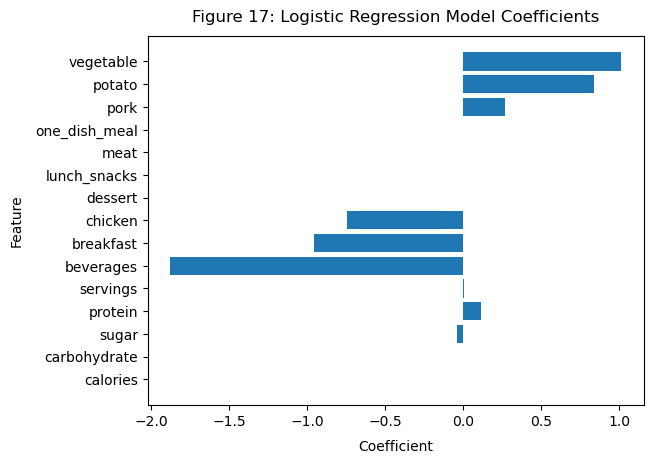

In [39]:
# extract lr model coefficients
coefficients = lr.coef_[0]

# generate bar plot of logistic regression coefficients
plt.barh(features, coefficients)
plt.title('Figure 17: Logistic Regression Model Coefficients', pad=10.0)
plt.xlabel('Coefficient', labelpad=8.0)
plt.ylabel('Feature', labelpad=8.0)
plt.show()

# 6. Key Performance Indicator

With a business goal of predicting popular recipes at least 80% of the time, Tasty Bytes needs to know the accuracy of each model in terms of the percent of correct predictions. The recommended key performance indicator (KPI) or metric to monitor is model accuracy, as provided in the previous section. Accuracy describes the proportion (or percent) of the model's predictions that are correct. By this definition of the KPI, both models (with accuracies of 81%) are estimated to meet Tasty Bytes' business goal of predicting popular recipes at least 80% of the time. Logistic regression is recommended over SVM based on its higher simplicity, speed, and interpretability.

# 7. Summary and Recommendations

In summary, the Tasty Bytes product team would like to know if there is a way to predict which recipes, if featured on the company's home page, would lead to high website traffic. The predictions should be correct at least 80% of the time. An automated system for choosing popular recipes would benefit the organization in terms of increasing website traffic and subscriptions to meal planning and ingredient delivery services. This analysis has addressed the business goals by training and evaluating models that predict if a recipe will lead to high website traffic.

The logistic regression and SVM models displayed identical performance on the test dataset: 81% accuracy, 85% precision, and 83% recall. In other words, the models were equally able to discern between popular and unpopular recipes and they detected equal amounts of popular recipes in the test data. It is recommended that Tasty Bytes moves forward with additional testing and development of the logistic regression model since it is simpler, faster, and more interpretable than SVM.

Exploratory data analysis and logistic regression model evaluation revealed that recipes categorized as 'vegetable', 'potato', and 'pork' are most associated with high website traffic, suggesting that they should be featured on the home page. Conversely, recipes categorized as 'beverages' are most associated with low website traffic, suggesting that they should not be featured on the home page.

Future work should include expansion of the dataset. Additional recipes can be added as they become available. Furthermore, additional recipe attributes should be collected and tested for their influence on website traffic and effect on model performance. These include the time required to make each recipe, cost per serving, associated diet (e.g., 'vegan', 'gluten-free'), time of year when the recipe was featured (e.g., around a specific holiday), and more.

Testing of additional classification algorithms should be performed. It is possible that another algorithm will perform better than logistic regression on this application and dataset. Further optimization can be conducted with techniques such as feature engineering, feature selection, and additional hyperparameter tuning. Model accuracy is the KPI that should be monitored throughout the model development process.

Finally, accuracy is an appropriate model evaluation metric only when datasets are reasonably balanced with respect to the target variable class. The provided dataset and resulting training and test sets are reasonably balanced with a 39% 'Not High' and 61% 'High' target class distribution. If, in the future, the dataset becomes less balanced (e.g., 30% and 70%), then the recommended model evaluation metric is the F1 score. This metric represents the harmonic mean of precision and recall, and is more appropriate for imbalanced datasets.